# Feature selection with null importances

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind

# automated feature engineering
import featuretools as ft

# Filter out pandas warnings
import warnings

warnings.filterwarnings("ignore")

start = "\033[1m"  # Bold text
end = "\033[0;0m"  # Reset text
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

%matplotlib inline

import warnings

warnings.simplefilter("ignore", UserWarning)
InteractiveShell.ast_node_interactivity = "all"
import sys

sys.path.append("../")
from helpers import *

In [2]:
if os.path.exists("../features_data/feature_matrix_final.csv"):
    feature_matrix_spec = pd.read_csv("../features_data/feature_matrix_final.csv")


feature_matrix_spec.head(10)
feature_matrix_spec = clean_feature_names(feature_matrix_spec)
feature_matrix_spec.replace([np.inf, -np.inf], np.nan, inplace=True)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,SUM(credit.previous.DAYS_LAST_DUE),SUM(credit.previous.DAYS_LAST_DUE_1ST_VERSION),SUM(credit.previous.DAYS_TERMINATION),SUM(credit.previous.HOUR_APPR_PROCESS_START),SUM(credit.previous.NFLAG_INSURED_ON_APPROVAL),SUM(credit.previous.NFLAG_LAST_APPL_IN_DAY),SUM(credit.previous.RATE_DOWN_PAYMENT),SUM(credit.previous.RATE_INTEREST_PRIMARY),SUM(credit.previous.RATE_INTEREST_PRIVILEGED),SUM(credit.previous.SELLERPLACE_AREA)
0,100002,1,Cash loans,M,N,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,270000.0,1293502.5,35698.5,1129500.0,Family,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,2191458.0,2191458.0,2191458.0,90.0,0.0,6.0,0.0,0.0,0.0,-6.0
4,100007,0,Cash loans,M,N,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,99000.0,490495.5,27517.5,454500.0,"Spouse, partner",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,100009,0,Cash loans,F,Y,171000.0,1560726.0,41301.0,1395000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,100010,0,Cash loans,M,Y,360000.0,1530000.0,42075.0,1530000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,112500.0,1019610.0,33826.5,913500.0,Children,...,-93018.0,27027982.0,27027982.0,740.0,0.0,74.0,0.0,0.0,0.0,0.0
9,100012,0,Revolving loans,M,N,135000.0,405000.0,20250.0,405000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data = feature_matrix_spec

categorical_feats = [
    f
    for f in data.columns
    if data[f].dtype == "object" or data[f].dtype.name == "category"
]

categorical_feats
for f_ in categorical_feats:
    data[f_], _ = pd.factorize(data[f_])
    # Set feature type as categorical
    data[f_] = data[f_].astype("category")


def encode_features(data):
    for col in data.select_dtypes(include=["category", "object"]).columns:
        data[col] = pd.factorize(data[col])[0]
    return data


def get_feature_importances(data, shuffle, seed=None):
    # Specify the features and target variable
    train_features = [f for f in data if f not in ["TARGET", "SK_ID_CURR"]]
    y = data["TARGET"].copy()

    # Shuffle the target if required
    if shuffle:
        y = data["TARGET"].sample(frac=1.0, random_state=seed)

    # Set up the data matrix for XGBoost
    dtrain = xgb.DMatrix(data[train_features], label=y)

    # XGBoost parameters
    xgb_params = {
        "objective": "binary:logistic",
        "colsample_bylevel": 0.7,
        "colsample_bynode": 1.0,
        "colsample_bytree": 0.7,
        "gamma": 5.0,
        "learning_rate": 0.08807219785563987,
        "max_depth": 4,
        "min_child_weight": 3,
        "n_estimators": 300,
        "reg_alpha": 1e-05,
        "reg_lambda": 1.0,
        "subsample": 0.85,
        "tree_method": "gpu_hist",
        "seed": seed,
        "enable_categorical": True,
    }

    # Train the model
    clf = xgb.train(xgb_params, dtrain, num_boost_round=200)

    # Get feature importances
    importance_gain = clf.get_score(importance_type="gain")
    importance_split = clf.get_score(importance_type="weight")

    # Create a DataFrame to store feature importances
    imp_df = pd.DataFrame(
        {
            "feature": list(importance_gain.keys()),
            "importance_gain": list(importance_gain.values()),
            "importance_split": [
                importance_split.get(f, 0) for f in importance_gain.keys()
            ],
        }
    )

    return imp_df


# Initialize random seed
np.random.seed(123)

data_encoded = encode_features(data.copy())
actual_imp_df = get_feature_importances(data=data_encoded, shuffle=False)
print(actual_imp_df.head())

# Running multiple shuffles to estimate null importance
null_imp_df = pd.DataFrame()
nb_runs = 100
start = time.time()
dsp = ""

for i in range(nb_runs):
    imp_df = get_feature_importances(data=data_encoded, shuffle=True, seed=i)
    imp_df["run"] = i + 1
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)

    # Erase previous message
    print("\r" + " " * len(dsp), end="")
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = "Done with %4d of %4d (Spent %5.1f min)" % (i + 1, nb_runs, spent)
    print("\r" + dsp, end="")

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'WALLSMATERIAL_MODE',
 'prev_PRODUCT_COMBINATION']

              feature  importance_gain  importance_split
0  NAME_CONTRACT_TYPE        90.901749               2.0
1         CODE_GENDER        80.896599              29.0
2        FLAG_OWN_CAR        74.292580               3.0
3    AMT_INCOME_TOTAL        17.213676               4.0
4          AMT_CREDIT        32.353550              15.0
Done with  100 of  100 (Spent  23.7 min)

In [ ]:
null_imp_df.to_csv("../importances/null_importances_distribution_rf_final.csv")
actual_imp_df.to_csv("../importances/actual_importances_ditribution_rf_final.csv")

In [ ]:
null_imp_df = pd.read_csv("../importances/null_importances_distribution_rf_final.csv")
# drop unnamed column
null_imp_df.drop(null_imp_df.columns[0], axis=1, inplace=True)
actual_imp_df = pd.read_csv(
    "../importances/actual_importances_ditribution_rf_final.csv"
)
actual_imp_df.drop(actual_imp_df.columns[0], axis=1, inplace=True)

null_imp_df.head()
actual_imp_df.head()

,feature,importance_gain,importance_split,run
0,NAME_CONTRACT_TYPE,0.000000,0,1
1,CODE_GENDER,15.826296,20,1
2,FLAG_OWN_CAR,14.396300,10,1
3,AMT_INCOME_TOTAL,726.291291,101,1
4,AMT_CREDIT,1046.419406,113,1


,feature,importance_gain,importance_split
0,NAME_CONTRACT_TYPE,282.746096,6
1,CODE_GENDER,4887.967188,89
2,FLAG_OWN_CAR,149.629799,4
3,AMT_INCOME_TOTAL,938.896204,23
4,AMT_CREDIT,5376.895796,102


In [8]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(
        null_imp_df_.loc[
            null_imp_df_["feature"] == feature_, "importance_split"
        ].values,
        label="Null importances",
    )
    ax.vlines(
        x=actual_imp_df_.loc[
            actual_imp_df_["feature"] == feature_, "importance_split"
        ].mean(),
        ymin=0,
        ymax=np.max(a[0]),
        color="r",
        linewidth=10,
        label="Real Target",
    )
    ax.legend()
    ax.set_title("Split Importance of %s" % feature_.upper(), fontweight="bold")
    plt.xlabel("Null Importance (split) Distribution for %s " % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(
        null_imp_df_.loc[null_imp_df_["feature"] == feature_, "importance_gain"].values,
        label="Null importances",
    )
    ax.vlines(
        x=actual_imp_df_.loc[
            actual_imp_df_["feature"] == feature_, "importance_gain"
        ].mean(),
        ymin=0,
        ymax=np.max(a[0]),
        color="r",
        linewidth=10,
        label="Real Target",
    )
    ax.legend()
    ax.set_title("Gain Importance of %s" % feature_.upper(), fontweight="bold")
    plt.xlabel("Null Importance (gain) Distribution for %s " % feature_.upper())

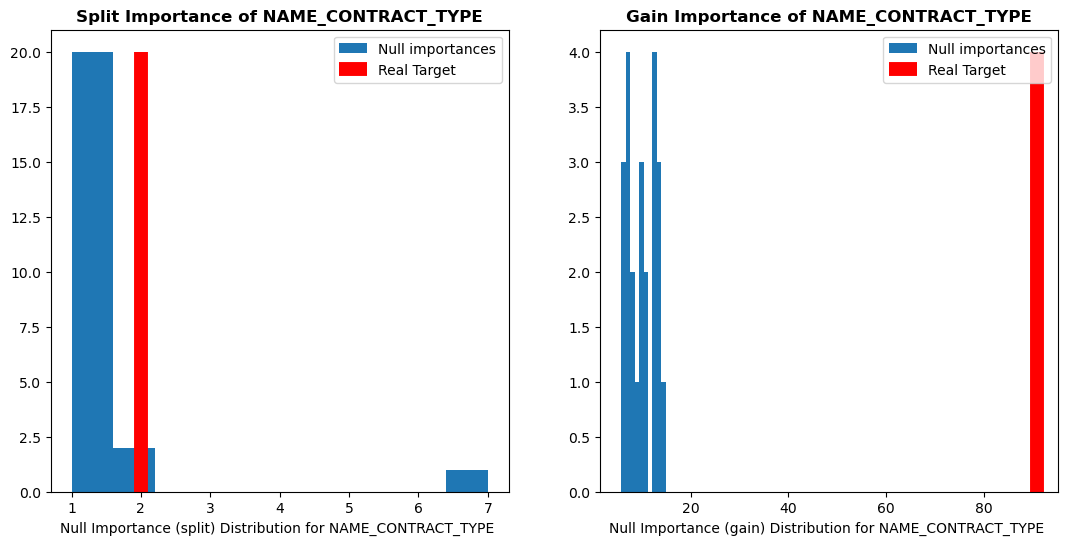

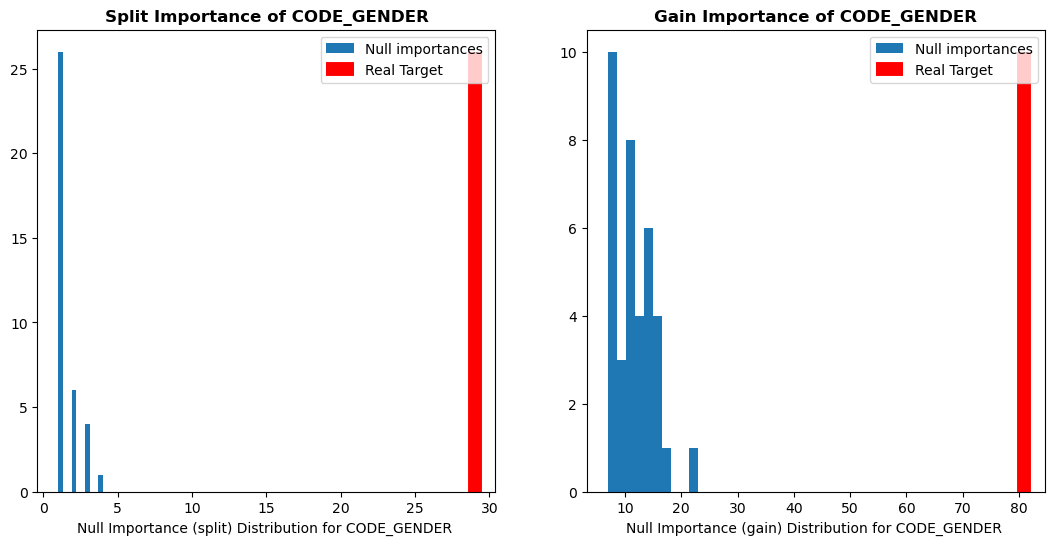

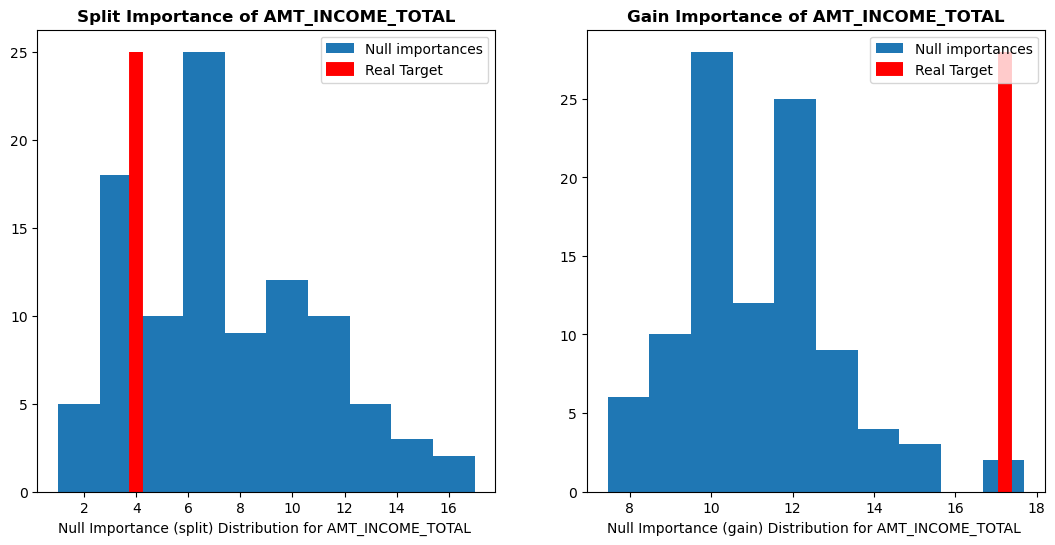

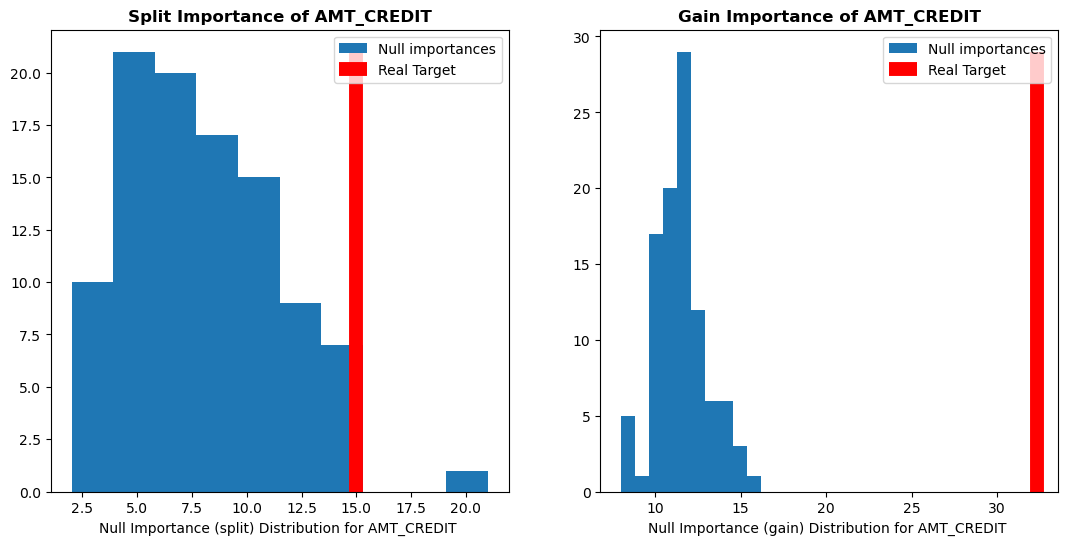

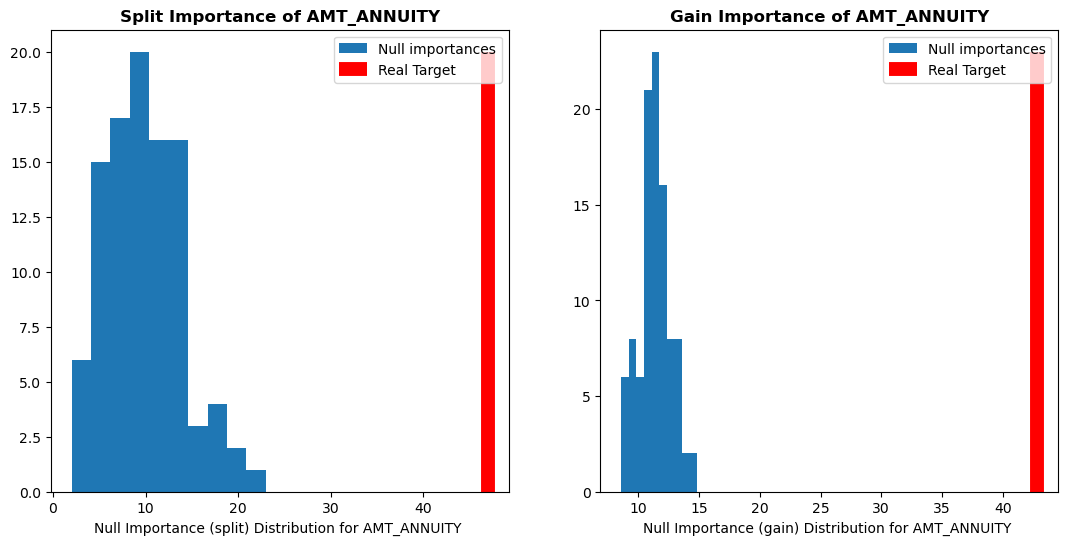

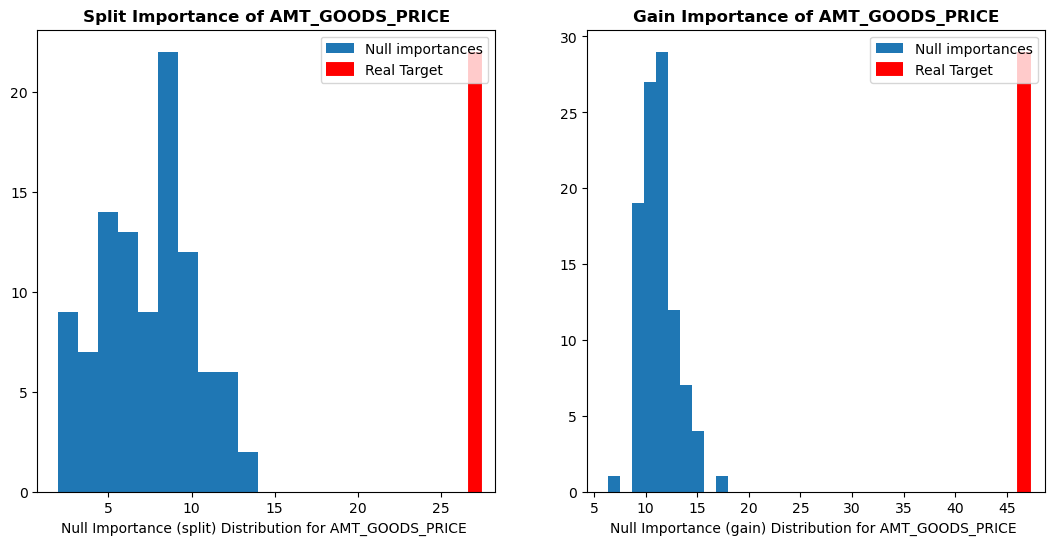

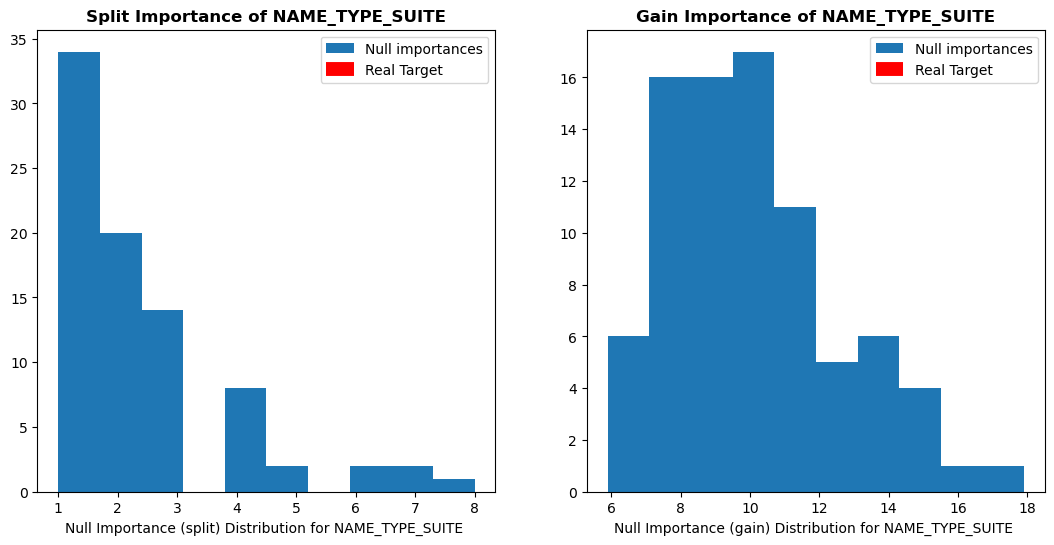

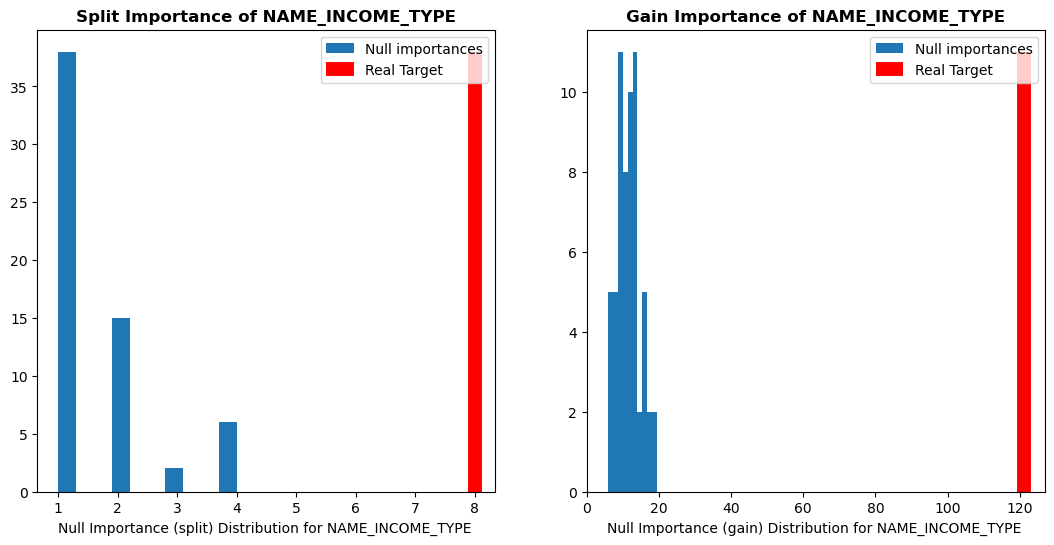

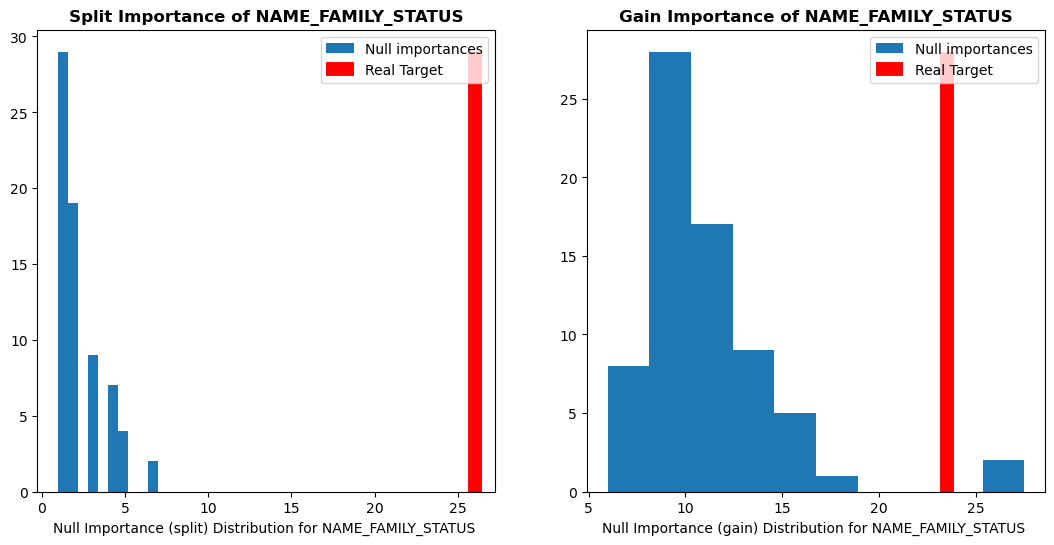

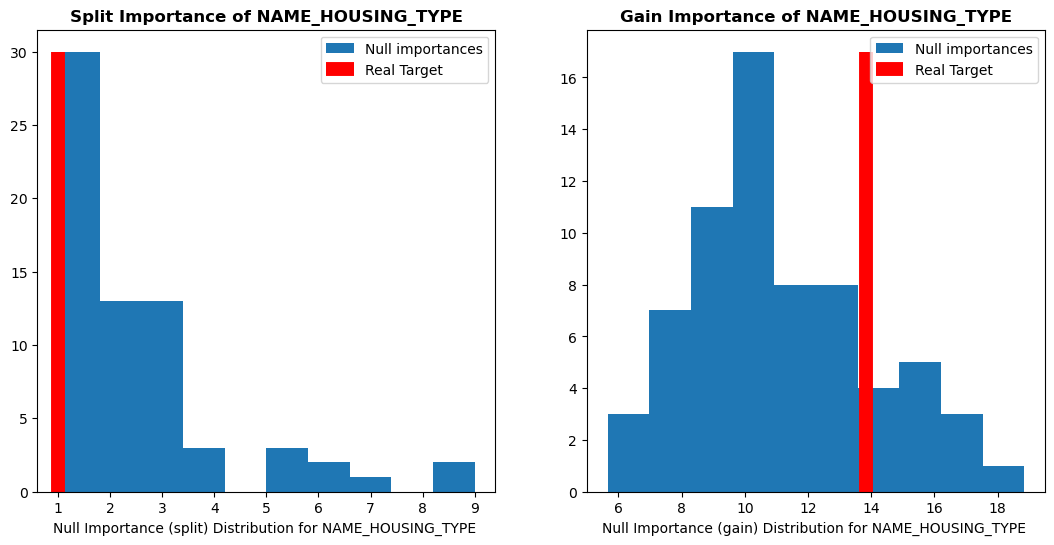

In [9]:
for feature in null_imp_df.feature[:10]:
    display_distributions(
        actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_=feature
    )

### Best features

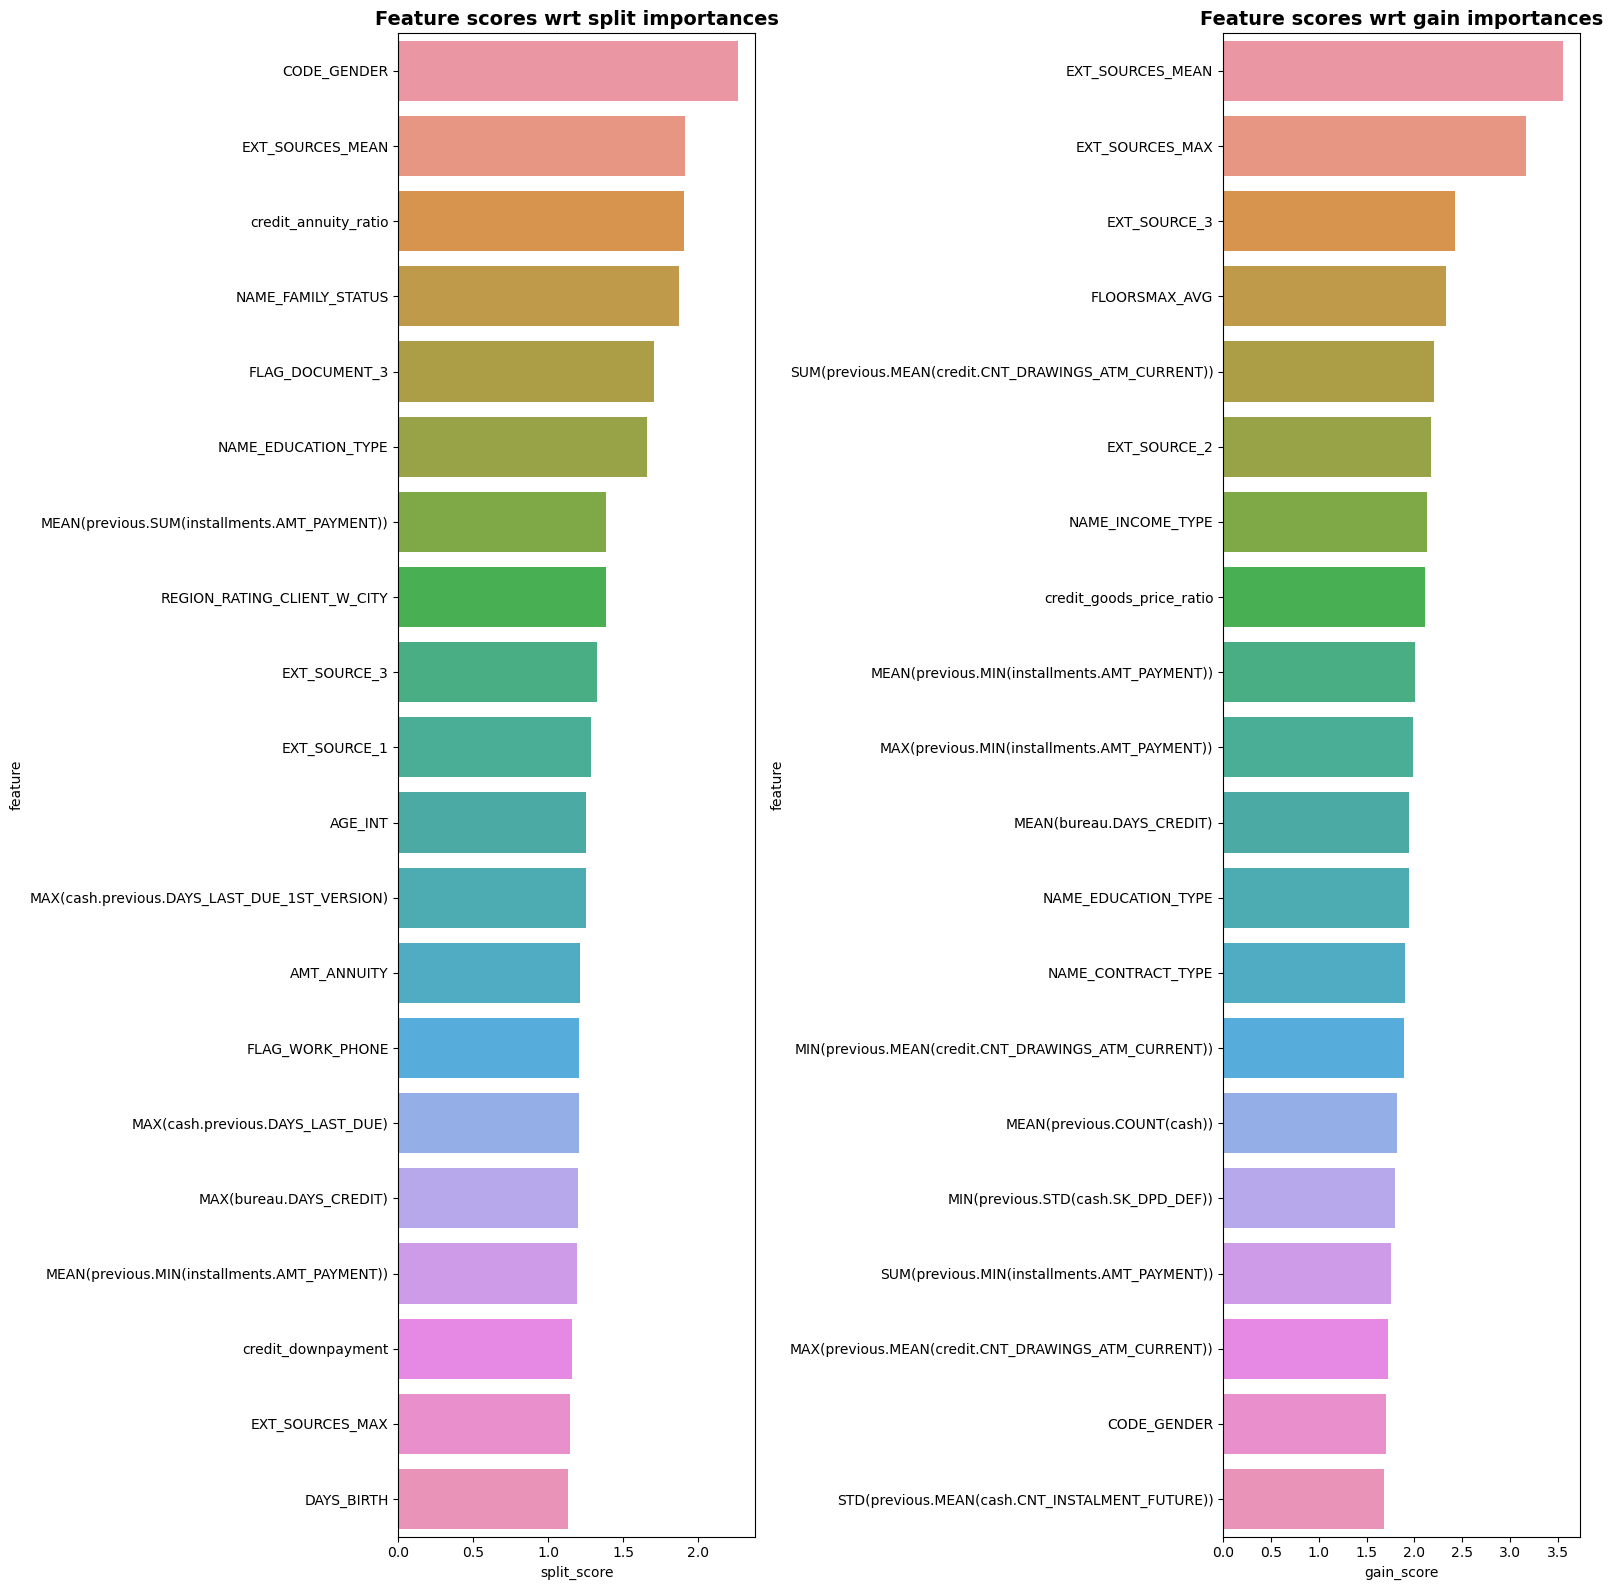

In [10]:
feature_scores = []
for _f in actual_imp_df["feature"].unique():
    f_null_imps_gain = null_imp_df.loc[
        null_imp_df["feature"] == _f, "importance_gain"
    ].values
    f_act_imps_gain = actual_imp_df.loc[
        actual_imp_df["feature"] == _f, "importance_gain"
    ].mean()
    if f_null_imps_gain.size > 0:
        gain_score = np.log(
            1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75))
        )  # Avoid divide by zero
    else:
        gain_score = -1

    f_null_imps_split = null_imp_df.loc[
        null_imp_df["feature"] == _f, "importance_split"
    ].values
    f_act_imps_split = actual_imp_df.loc[
        actual_imp_df["feature"] == _f, "importance_split"
    ].mean()
    if f_null_imps_split.size > 0:
        split_score = np.log(
            1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75))
        )  # Avoid divide by zero
    else:
        split_score = -1

    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(
    feature_scores, columns=["feature", "split_score", "gain_score"]
)

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(
    x="split_score",
    y="feature",
    data=scores_df.sort_values("split_score", ascending=False).iloc[0:20],
    ax=ax,
)
ax.set_title("Feature scores wrt split importances", fontweight="bold", fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(
    x="gain_score",
    y="feature",
    data=scores_df.sort_values("gain_score", ascending=False).iloc[0:20],
    ax=ax,
)
ax.set_title("Feature scores wrt gain importances", fontweight="bold", fontsize=14)
plt.tight_layout();

### Worst features

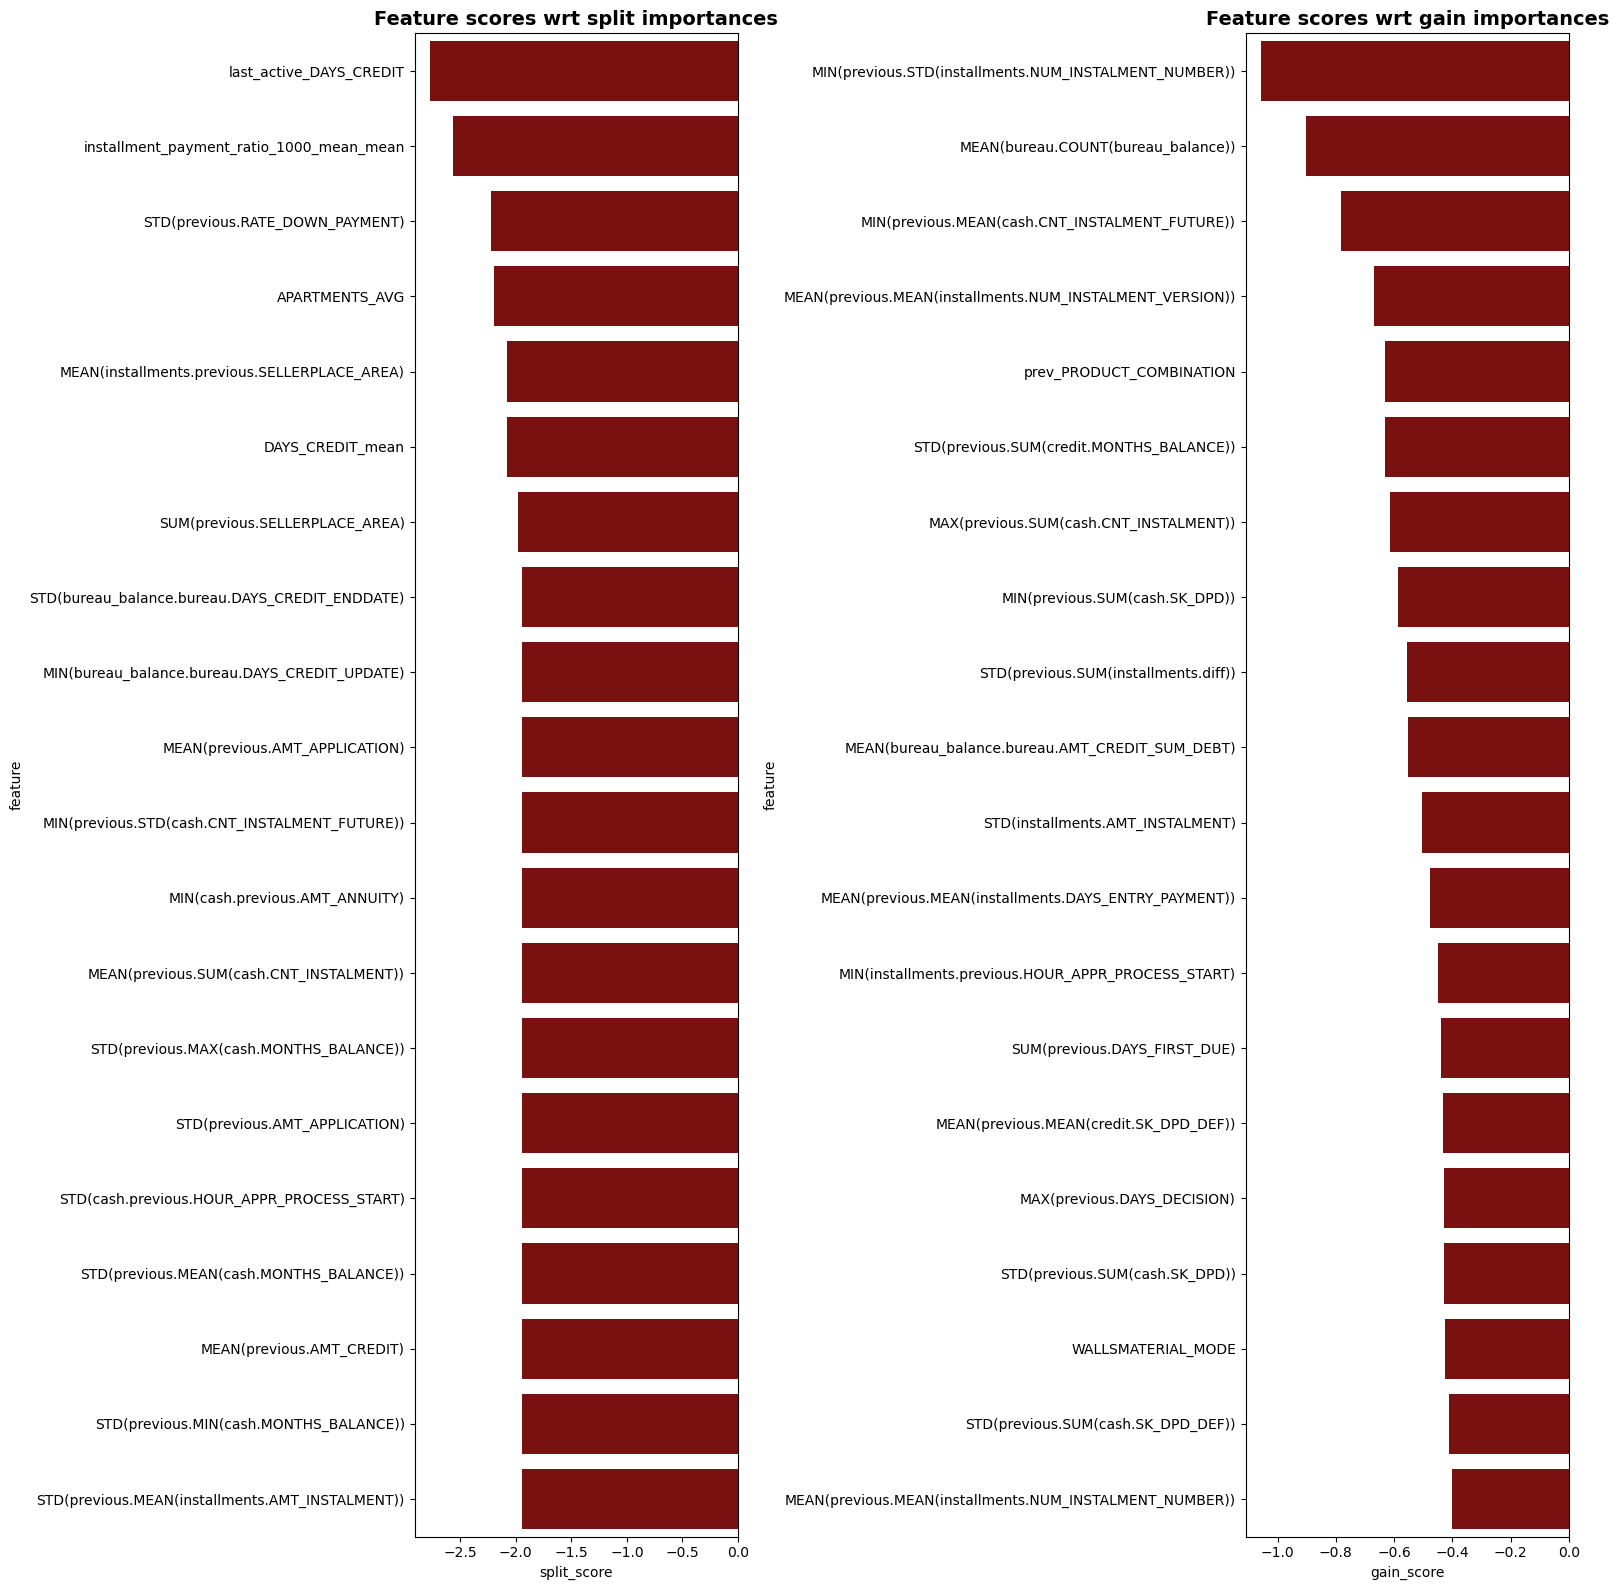

In [11]:
plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(
    x="split_score",
    y="feature",
    data=scores_df.sort_values("split_score", ascending=True).iloc[0:20],
    ax=ax,
    color="darkred",
)
ax.set_title("Feature scores wrt split importances", fontweight="bold", fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(
    x="gain_score",
    y="feature",
    data=scores_df.sort_values("gain_score", ascending=True).iloc[0:20],
    ax=ax,
    color="darkred",
)
ax.set_title("Feature scores wrt gain importances", fontweight="bold", fontsize=14)
plt.tight_layout();

### Removing useless features

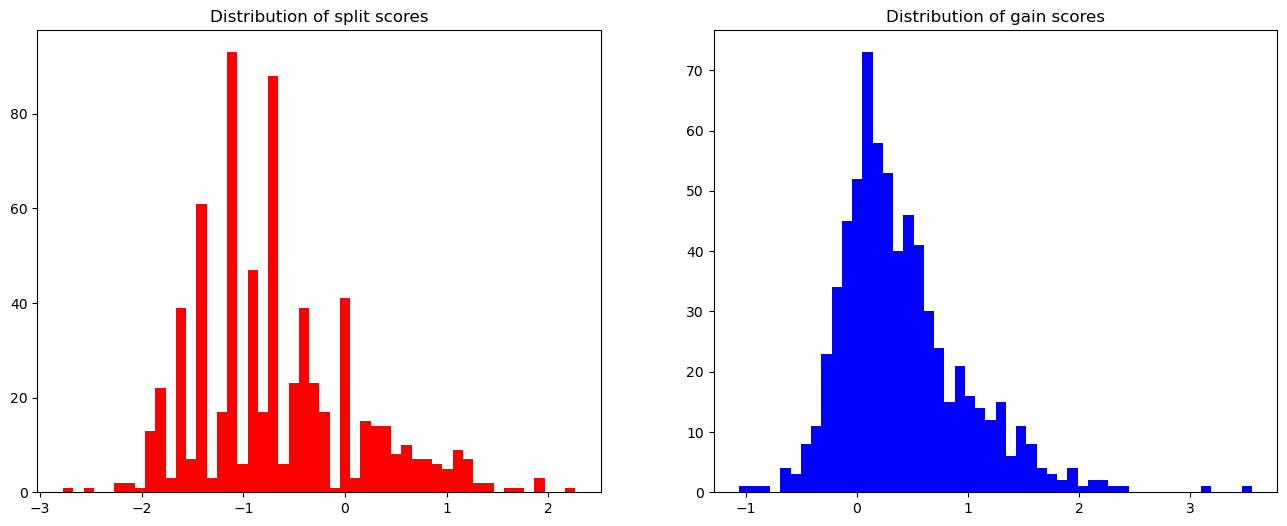

In [18]:
# plot the distribution of both split and gain scores
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.hist(scores_df["split_score"], bins=50, color="r")
plt.title("Distribution of split scores")

plt.subplot(1, 2, 2)
plt.hist(scores_df["gain_score"], bins=50, color="b")
plt.title("Distribution of gain scores")
plt.show();

In [61]:
split_score_threshold = 0
gain_score_threshold = 0

# Filter features based on thresholds
useful_features = scores_df[
    (scores_df["split_score"] > split_score_threshold)
    & (scores_df["gain_score"] > gain_score_threshold)
]

len(useful_features)

# remove keep only useful features from feature matrix
feature_matrix_spec_testing = feature_matrix_spec[
    ["TARGET"] + useful_features.feature.to_list()
]

152

#### Data preparation

In [62]:
from sklearn.model_selection import train_test_split

dummied_feature_matrix = pd.get_dummies(feature_matrix_spec_testing)
len(dummied_feature_matrix.columns)
features = dummied_feature_matrix
# Only numeric features
features = features.select_dtypes("number")

# Extract the labels
labels = np.array(features["TARGET"].astype(np.int32)).reshape((-1,))
# features = features.drop(columns = ['TARGET'])

# filter features to only include top features
features = features[dummied_feature_matrix.columns.to_list()]

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, random_state=42
)

# Separate features and target for the training data
X_train = train_features.drop(columns=["TARGET"])
y_train = train_features["TARGET"]

# Separate features and target for the testing data
X_test = test_features.drop(columns=["TARGET"])
y_test = test_features["TARGET"]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_test = clean_feature_names(X_test)

# Replace infinite values with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

print("Final Train shape: ", X_train.shape)
print("Final Test shape: ", X_test.shape)

248

Final Train shape:  (230633, 247)
Final Test shape:  (76878, 247)


In [63]:
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Initialize and train the model
model = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", verbosity=0, tree_method="gpu_hist"
)
model.fit(X_train_imputed, y_train)

# Predict probabilities and calculate AUC
y_pred_proba = model.predict_proba(X_test_imputed)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
auc

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

0.7747575124653406

ONLY GAIN:

- all data: 0.7719411159577487
- -0.5: 0.7717095331804574
- 0: 0.769894327841386
- 0.5: 0.7707913483484126

BOTH FILTERS:
- all data: 0.7719411159577487
- -2: 0.7704187927031303
- -1: 0.7717690272817496

- **0: 0.7747575124653406(best)**

-  0.5: 0.7735819909664436
-  2: 0.7087799366001187

### Removing highly correlated features

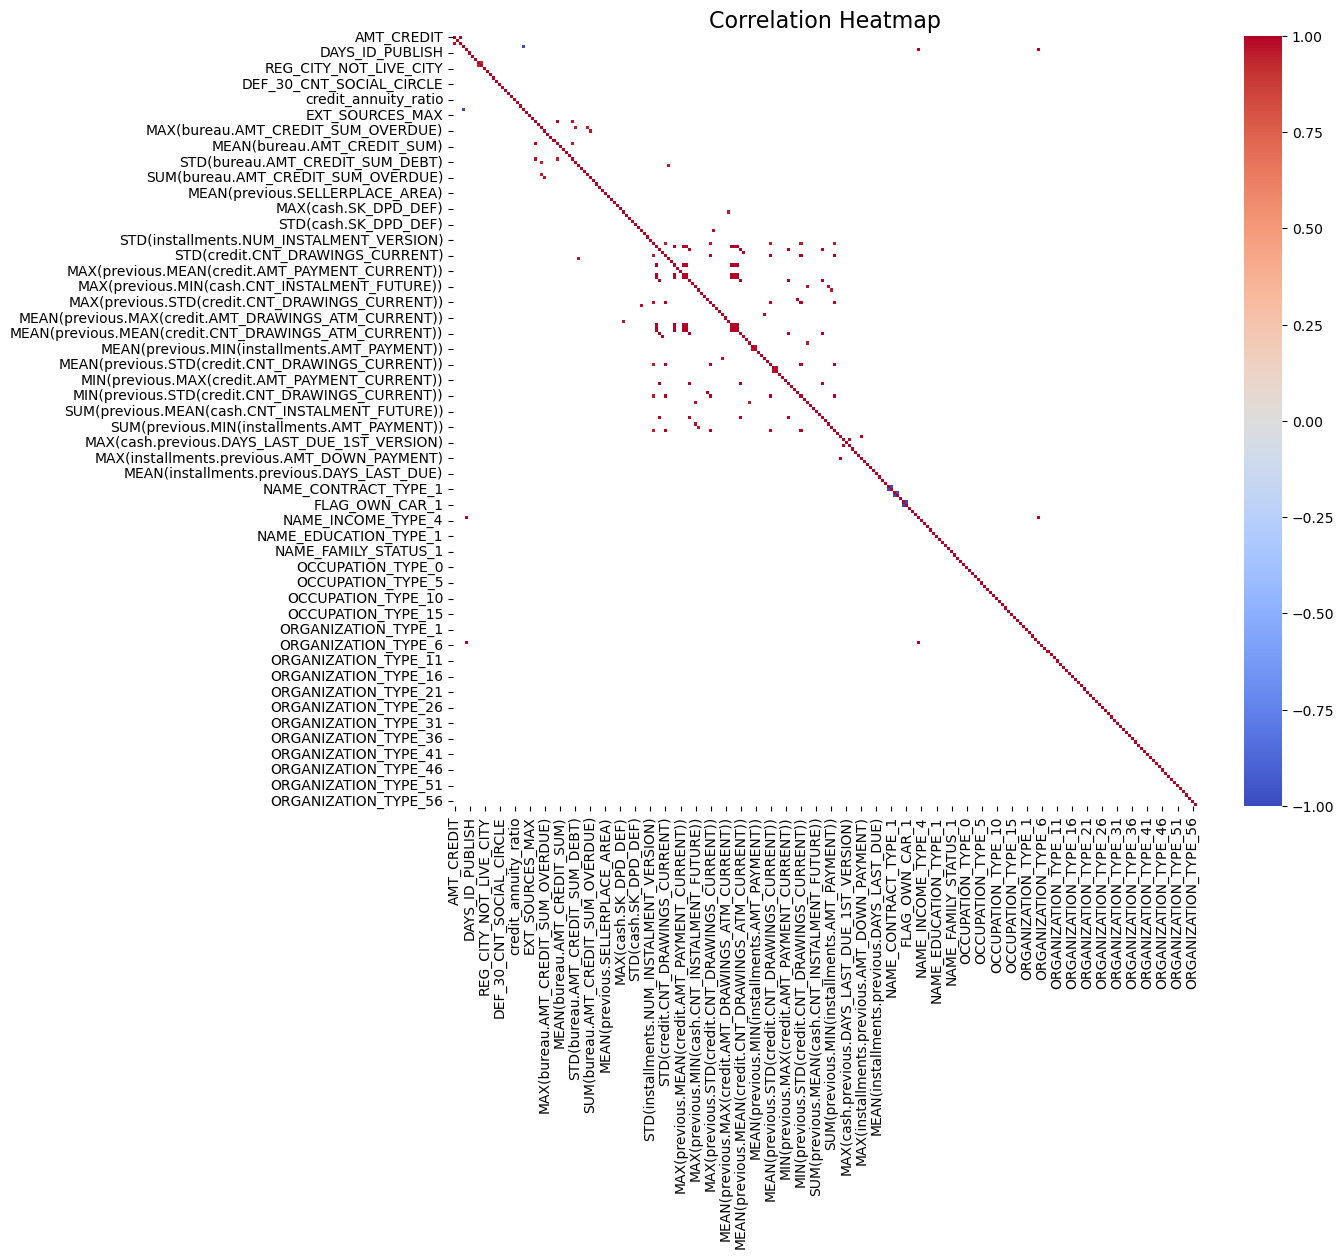

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the correlation matrix
corr = X_train.corr()

# Create a mask to display only correlations above a certain threshold
mask = corr.abs() <= 0.95

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, vmin=-1, vmax=1, annot=False)
plt.title("Correlation Heatmap", fontsize=16)
plt.show();

In [65]:
def remove_highly_correlated_features(X, threshold=0.95):
    # Create correlation matrix
    corr_matrix = X.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find index of feature columns with correlation greater than the threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    return to_drop


# Identify the features to drop from the training set
features_to_drop = remove_highly_correlated_features(X_train, threshold=0.95)

# Drop the features from the training set
X_train_reduced = X_train.drop(columns=features_to_drop)

# Drop the same features from the test set
X_test_reduced = X_test.drop(columns=features_to_drop)

print("Reduced training set shape:", X_train_reduced.shape)
print("Reduced test set shape:", X_test_reduced.shape)

Reduced training set shape: (230633, 206)
Reduced test set shape: (76878, 206)
(230633,)


In [66]:
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer

# Initialize and train the model
model = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", verbosity=0, tree_method="gpu_hist"
)
model.fit(X_train_reduced, y_train)

# Predict probabilities and calculate AUC
y_pred_proba = model.predict_proba(X_test_reduced)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
auc

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

0.7748456739213633

Percentage of features dropped after removing highly correlated features

In [67]:
len(features_to_drop) / X_train.shape[1] * 100

16.599190283400812

<Figure size 2000x200 with 0 Axes>

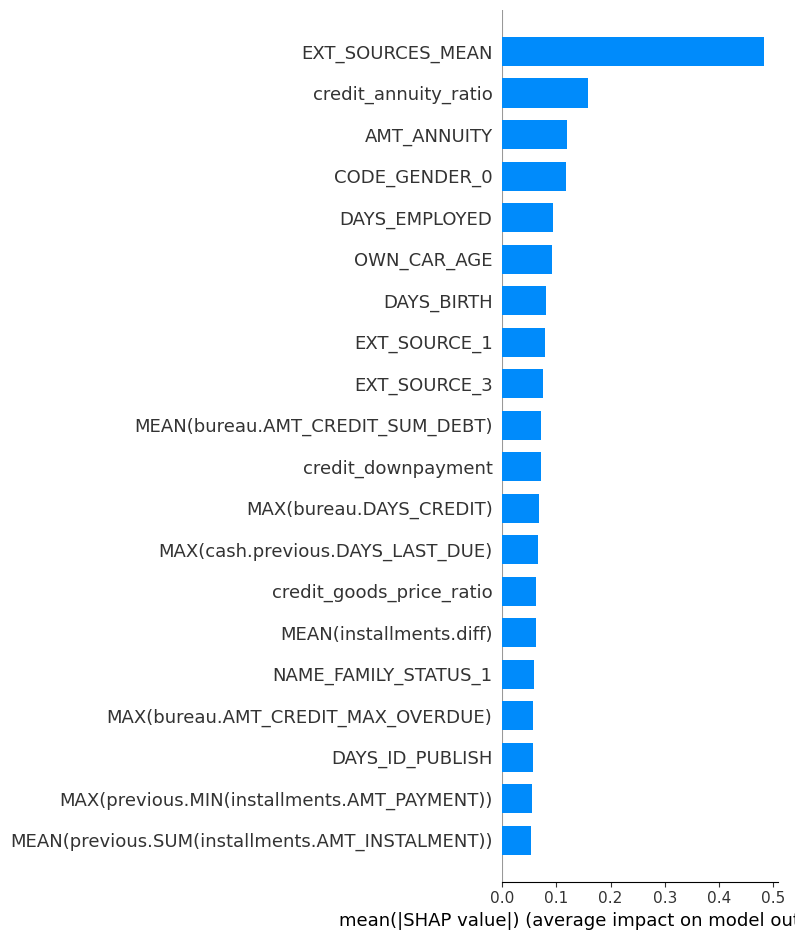

In [96]:
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(model)
shap_values = explainer(X_train_reduced)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_train_reduced, feature_names=X_train_reduced.columns, plot_type="bar")

# Show the plot
plt.show()


## Saving the train/test data

In [92]:
print("Final Train shape: ", X_train_reduced.shape)
print("Final Test shape: ", X_test_reduced.shape)

Final Train shape:  (230633, 206)
Final Test shape:  (76878, 206)


In [91]:
# save train and test to disk
X_train_reduced.to_csv("../training_data/X_train_reduced.csv", index=False)
y_train.to_csv("../training_data/y_train.csv", index=False)
X_test_reduced.to_csv("../training_data/X_test_reduced.csv", index=False)
y_test.to_csv("../training_data/y_test.csv", index=False)